## Import

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import nibabel as nib

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiplicativeLR

from torchsummary import summary

%matplotlib inline

They have only one size. Below code checks the size of the all the files

In [2]:
# set(nib.load(b).get_fdata().shape for b in glob('blurred/*.BRIK'))

## Model

In [3]:
from model import *

In [4]:
model = DeepBrain(inplanes=179, planes=3)

G:\내 드라이브\termpj\model.py:102: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(summary(model, input_size=(179, 72, 72, 36)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 3, 72, 72, 36]             540
       BatchNorm3d-2        [-1, 3, 72, 72, 36]               6
              ReLU-3        [-1, 3, 72, 72, 36]               0
            Conv3d-4       [-1, 16, 36, 36, 18]           1,312
       BatchNorm3d-5       [-1, 16, 36, 36, 18]              32
              ReLU-6       [-1, 16, 36, 36, 18]               0
            Conv3d-7       [-1, 32, 36, 36, 18]             544
       BatchNorm3d-8       [-1, 32, 36, 36, 18]              64
            Conv3d-9       [-1, 32, 36, 36, 18]          13,856
      BatchNorm3d-10       [-1, 32, 36, 36, 18]              64
             ReLU-11       [-1, 32, 36, 36, 18]               0
           Conv3d-12       [-1, 32, 36, 36, 18]          27,680
      BatchNorm3d-13       [-1, 32, 36, 36, 18]              64
             ReLU-14       [-1, 32, 36,

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## DataLoader

In [6]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    
    def __init__(self, datatype='blur', test=False):
        
        if datatype == 'blur':
            self.datafiles = glob('blurred/*.BRIK')
            
        elif datatype == 'scale':
            self.datafiles = glob('scaled/*.BRIK')
            
        else:
            pass
    
        if test: self.datafiles[-5:]
        else: self.datafiles[:-5]
        self.demographics = pd.read_csv('participants_with_runs.csv')
        
    def __getitem__(self, idx):
        
        x = torch.tensor(nib.load(self.datafiles[idx]).get_fdata()).float()
        y = torch.tensor(self.demographics.loc[idx].YB).float()
        
        return x, y
    
    def __len__(self):
        return len(self.datafiles)

In [7]:
dset = MyDataset('scale')
dloader = DataLoader(dset)

## Run

Many loss functions were used in turn.

In [8]:
# loss_fn = nn.BCELoss(weight=torch.Tensor([1/44, 1/25]))
weight = torch.FloatTensor([(1/44)**2, (1/25)**2]).to(device)
# loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([1/44, 1/25]).to(device))
loss_fn = nn.CrossEntropyLoss(weight=weight)
# loss_fn = nn.CrossEntropyLoss()

Scheduler was meaningless. I've commented that out

In [9]:
optimizer = optim.Adam(model.parameters())
# scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.97)

In [10]:
to_np = lambda t: t.cpu().detach().numpy()

In [11]:
losses, ans, accs = [], [], []
for e in range(10):
    
    print(f"Epoch {e}")
    epoch_pred, epoch_true = [], []
    bth_loss = 0
    for i, (x, y) in enumerate(dloader):
        
        x, y = x.permute(0, 4, 1, 2, 3).to(device), y.to(device)
        epoch_true.append(round(float(y)))
        
        optimizer.zero_grad()
        
        y_pred = model.forward(x).to(device)
        epoch_pred.append(to_np(y_pred.argmax()))
        
        loss = loss_fn(y_pred, y.type(torch.long))
        bth_loss += loss.item()
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
    torch.cuda.empty_cache()
    
    losses.append(bth_loss / len(dloader))
    ans.append((epoch_true, epoch_pred))
    
#     if e % 10 == 0:
#         plt.title(f'Loss of Epoch {e+1}')
#         plt.plot(losses)
#         plt.grid()
        
#         plt.title(f'Accuracy of Epoch {e+1}')
#         plt.plot(accs)
#         plt.grid()
    
    print(classification_report(epoch_true, np.array(epoch_pred) > 0.5))
    accs.append(classification_report(epoch_true, np.array(epoch_pred) > 0.5).split('\n')[5].split()[1])

Epoch 0
              precision    recall  f1-score   support

           0       0.64      0.98      0.77        44
           1       0.50      0.04      0.07        25

    accuracy                           0.64        69
   macro avg       0.57      0.51      0.42        69
weighted avg       0.59      0.64      0.52        69

Epoch 1
              precision    recall  f1-score   support

           0       0.69      0.93      0.80        44
           1       0.70      0.28      0.40        25

    accuracy                           0.70        69
   macro avg       0.70      0.61      0.60        69
weighted avg       0.70      0.70      0.65        69

Epoch 2
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        44
           1       0.68      0.60      0.64        25

    accuracy                           0.75        69
   macro avg       0.73      0.72      0.73        69
weighted avg       0.75      0.75      0.75       

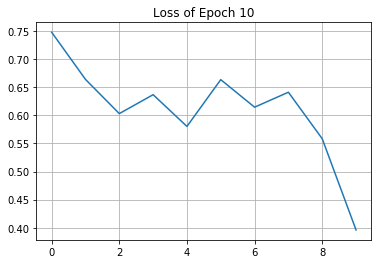

In [12]:
plt.title(f'Loss of Epoch {e+1}')
plt.plot(losses)
plt.grid()

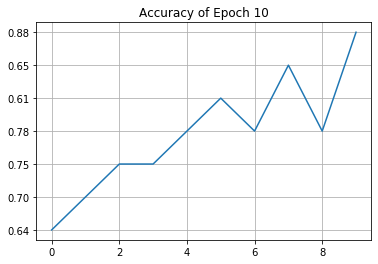

In [13]:
plt.title(f'Accuracy of Epoch {e+1}')
plt.plot(accs)
plt.grid()

## Guided Backpropagation

In [14]:
# torch.save(model, 'model.pth')
model= torch.load('model_scale.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'model_scale.pth'

In [ ]:
import nibabel as nib
from guided_backprop import GuidedBackprop

_ = model.eval()

# Remove LogSoftmax
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

GBP = GuidedBackprop(model)

In [ ]:
inputs, label = x.permute(3, 0, 1, 2), torch.BoolTensor(0)
input_img = nn.Parameter(torch.FloatTensor(inputs).unsqueeze(0), requires_grad=True).to(device)

guided_grads = GBP.generate_gradients(input_img, label)

export_gradient = np.zeros((3,75,93,81))
export_gradient[:, 8:-8, 8:-8, :-10] = guided_grads
nifti_img = nib.Nifti1Image(export_gradient.transpose(1, 2, 3, 0), np.eye(4))
nifti_img = nib.Nifti1Image(guided_grads.transpose(1, 2, 3, 0), np.eye(4))
nifti_img.to_filename('vis_tmp.nii.gz')

In [ ]:
nib.load('vis_tmp.nii.gz').get_data()[[nib.load('vis_tmp.nii.gz').get_fdata() != 0]]